In [1]:
# !pip install tensorflow
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, Layer
from tensorflow import keras
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold

from itertools import permutations, product
from statistics import mean
import random

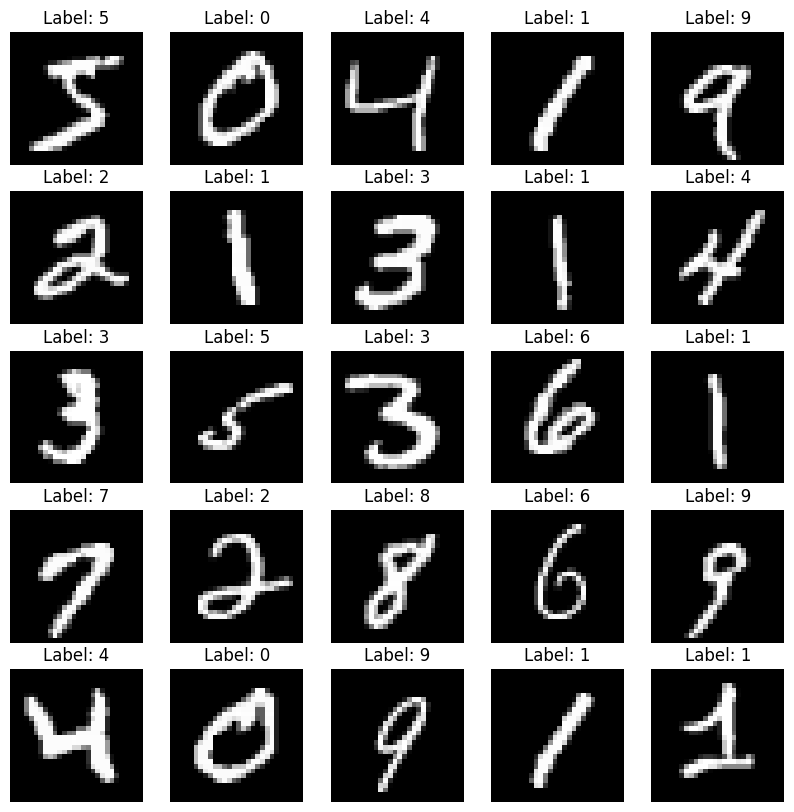

In [2]:
# Displaying the MNIST dataset
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Display the first few images from the training set
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    # plt.title(f"Label_x: {x_train[i]}")
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

In [3]:
class Classifier(BaseEstimator, TransformerMixin):
  """
  Creates and trains Convolutional Neural Networks
  on the Stratified 5 Fold, and will train and test on the MNIST classification
  task using CNN.

  ...
  Methods
  ```````
  make_model:
    makes desired Convolutional Neural Networks model with the given filter and
    learning rate
  evaluate:
    Evaluates model using stratified 5 fold and will return the mean of the scores
  optimal:
    Will make a model and will test it by using "make_model" and
    "evaluate" respectively, then will choose the model with the best mean score.
  fit:
    To fit the dataset with model and to find the optimal model
  transform:
    returns model
  summarize:
    To visualy summarize the trained models. Referenced from online tutorial.
  test:
    To test the model with the test MNIST data.
    Testing the performance of the model on the out-of-sample test from MNIST
  """

  def optimal(self, X):
    """ Will call "make_model" and "evaluate" to make a model with given hyperparameters
        and to evaluate the made model. The returned mean accuracy result will be
        stored in a dictionary along with its hyperparameter and the hyperparameter
        with the highest mean accuracy score will be most optimal model and returned.
        Since training takes hours with the MNIST dataset, I will be storing
        the model into my drive and will be testing with the MNIST dataset separately.

    Parameters
    ``````````
    X (DataFrame) : Data given but since we are using MNIST dataset, it can just
                    be called from Keras. So for this source code we are not going
                    to use X.

    Returns
    ```````
    ideal_model (Sequential) : The most optimal CNN model will be returned
    """
    # values = {}
    # for (column_name, column_data) in X.iteritems():
    #   values[column_name] = column_data
    # column_names = values.keys()

    num_filters = [16, 32]
    learning_rate = [0.001, 0.01]

    # The combination with the highest mean scores will be the optimal model
    # mean_result (key) : combo list (value)
    mean_results_dict = {}

    permutation = []

    scores, histories = list(), list()
    # for filter_combo in product(num_filters, repeat = 3):
    for filter in num_filters:
      temp_list = list()
      temp_list.append(filter)
      for rate in learning_rate:
        combo = [temp_list, rate]
        model = self.make_model(filter = temp_list, lr = rate)
        mean_results, model = self.evaluate(model, X)
        combo.append(model)
        # history = model
        scores.append(mean_results)
        # histories.append(history)
        mean_results_dict[mean_results] = combo
      permutation.append(temp_list)

    self.summarize(histories)
    print(permutation)
    optimal = 0
    for key in mean_results_dict:
      if key > optimal:
        optimal = key

    print(optimal)
    print("This is the dictionary", mean_results_dict)
    print("This is the optimal combo: ", mean_results_dict[optimal])
    arr_optimal = mean_results_dict[optimal]
    ideal_model = self.make_model(filter = arr_optimal[0], lr = arr_optimal[1])
    ideal_model = mean_results_dict[optimal][2]

    # This is the optimal hyper parameter after testing.
    # ideal_model = self.make_model(filter = [32], lr = 0.001)
    score, ideal_model = self.evaluate(ideal_model, X)
    ideal_model.summary()
    print("The Score is: ", score)
    return ideal_model

  # from https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
  # Deprecated
  def summarize(self, histories):
    for i in range(len(histories)):
      # plot loss
      plt.subplot(2, 1, 1)
      plt.title('Cross Entropy Loss')
      plt.plot(histories[i].history['loss'], color='blue', label='train')
      # plt.plot(histories[i].history['val_loss'], color='orange', label='test')
      # plot accuracy
      plt.subplot(2, 1, 2)
      plt.title('Classification Accuracy')
      plt.plot(histories[i].history['accuracy'], color='blue', label='train')
      # plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
      plt.show()
    return

  # Will evaluate the model using 5-fold
  # --- This will take a while to make ---
  def evaluate(self, model, X):
    """ Will evaluate the performance of the CNN model using stratified 5 Fold

    Parameters
    ``````````
    model (Sequential) : CNN model we are evaluating
    X (DataFrame) : Not used because we are using mnist data which can be loaded
                    from keras.

    Returns
    ```````
    mean_results (float) : returns the mean accuracy score of the stratified 5
                          folds scores of the given model.

    model (Sequential) : Returns the trained model.... Important
    """
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    y_train_encoded = to_categorical(y_train)
    y_test_encoded = to_categorical(y_test)

    # Define EarlyStopping callback to monitor accuracy and stop training when it's no longer improving
    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode = 'max')  # Monitor validation loss and wait for 3 epochs without improvement

    list_scores, histories = list(), list()
    skf = StratifiedKFold(n_splits = 5)
    for train, test in skf.split(X_train, y_train):
        model.fit(X_train[train], y_train_encoded[train], epochs = 10, batch_size = 10, callbacks = [early_stopping])
        score = model.evaluate(X_train[test], y_train_encoded[test], verbose = 0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1]) # we are only going to take into account the accuracy
        list_scores.append(score[1] * 100)

    print("These are the list of scores: ", list_scores)
    mean_results = mean(list_scores)
    return mean_results, model


  def make_model(self, filter = [], lr = 0.001):
    """ Makes the model from the code given on the lab slides, with the given
        hyperparameters.

    Parameters
    ``````````
    filter (int, list) : filter parameter for the CNN model
    lr (float) : learning rate value for the Adam optimizer.

    Returns
    ```````
    model (Sequential) : Compiled CNN model with the given hyperparameters.
    """
    # From Code given
    model = models.Sequential()

    #Define filters and convolutional layers here
    model.add(layers.Conv2D(filters=filter[0], kernel_size=(3, 3),
    activation='relu', input_shape=(28, 28, 1)))

    #Add a maxpooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    #Flatten the output and give it to a fully connected layer
    model.add(layers.Flatten())

    #One hidden layer maps the flattened neurons to output
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

  # DEPRECATED
  # Confirmed with TA that we are not using the CNN model of the given diagram,
  # but we are using the code that is already provided to make the model.
  def make_model2(self, filter = [], lr = 0.001):
    # Will make a model of version 2
    # From Diagram

    model = models.Sequential()
    #define filters and convolutional layers here
    # we have 16, 3x3 filters.
    # Each of the 16 filters produces a 26×26 feature map.
    # So the output shape of the Conv2D layer in this case would be 26 x 26 x 16.
    model.add(layers.Conv2D(filters=filter[0], kernel_size=(3, 3), activation='relu',
          input_shape=(28, 28, 1)))

    #  The input_shape parameter is only required for the first layer in the model,
    # as subsequent layers can automatically infer
    # the input shape from the output shape of the previous layer.
    model.add(layers.Conv2D(filters=filter[1], kernel_size=(3, 3), activation='relu'))

    #Add a maxpooling layer
    # The max pooling layer reduces the dimension by a factor of 2 in this case.
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(filters=filter[2], kernel_size=(3, 3), activation='relu'))

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    #Flatten the output and give it to a fully connected layer
    model.add(layers.Flatten())
    #one hidden layer maps the flattened neurons to output
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

  def test(self, model):
    """ Will test the model with the MNIST test data and display test loss and
        accuracy

    Parameter:
    model (Sequential) : The most optimal model to be tested.
    """
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    y_train_encoded = to_categorical(y_train)
    y_test_encoded = to_categorical(y_test)

    # model.fit(X_train[train], y_train_encoded[train], epochs = 150, batch_size = 10, verbose = 0)
    print("We are going to test our ideal model on the out-of-sample data\n")
    score = model.evaluate(X_test, y_test_encoded)
    print("These are our scores: ")
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return

  # This will be executed when fit_transform is called.
  def fit(self, X, y=None):
    model = Sequential()
    model = self.optimal(X)
    print("This is the most optimal model... Yay!!!")
    model.summary()
    model.save("CNN_model.keras") # problem with loading saved models
    # Can't load. Costed about a full days worth of training.
    self.test(model)
    return self

  def transform(self, X):
    return X



In [4]:
model = Sequential()

# Not necessary
data = pd.DataFrame()
cnn = Classifier()
model = cnn.fit_transform(data)

Epoch 1/10
4800/4800 [==============================] - 19s 4ms/step - loss: 0.7584 - accuracy: 0.9287
Epoch 2/10
4800/4800 [==============================] - 17s 4ms/step - loss: 0.1219 - accuracy: 0.9644
Epoch 3/10
4800/4800 [==============================] - 17s 3ms/step - loss: 0.0996 - accuracy: 0.9704
Epoch 4/10
4800/4800 [==============================] - 17s 4ms/step - loss: 0.0836 - accuracy: 0.9755
Epoch 5/10
4800/4800 [==============================] - 17s 4ms/step - loss: 0.0755 - accuracy: 0.9790
Epoch 6/10
4800/4800 [==============================] - 17s 3ms/step - loss: 0.0702 - accuracy: 0.9799
Epoch 7/10
4800/4800 [==============================] - 17s 3ms/step - loss: 0.0693 - accuracy: 0.9816
Epoch 8/10
4800/4800 [==============================] - 17s 4ms/step - loss: 0.0615 - accuracy: 0.9835
Epoch 9/10
4800/4800 [==============================] - 17s 3ms/step - loss: 0.0620 - accuracy: 0.9843
Epoch 10/10
4800/4800 [==============================] - 17s 4ms/step - l

I only put epoch = 1, because it take so long to train a model.
I can implement "early stopping" so that it stops training the model once it stops improving, so it doesn't necessarily have to reach the desired epoch that I have setup for it.